<a href="https://colab.research.google.com/github/Camouflage10/RL-stocks/blob/experiment/get_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
!pip install yfinance
import yfinance as yf
import tensorflow as tf
import datetime
import math
import random
import json
n=80
lookAhead=60

1. set up game given 60 values guess buy or sell
2. graphing each step and wait for answer
3. setup a NN that catagorizes the state
4. setup RL model with the NN output plugiung in the states
5. optimize models

In [61]:
def getData(code, period, interval):
  df=yf.download(code,period=period,interval=interval)
  return df
data=getData("AAPL",'3mo','1h')
#normalize data between min max
data.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                                  Open        High         Low       Close  \
2022-02-14 09:30:00-05:00  167.369995  169.000000  167.089996  168.419998   
2022-02-14 10:30:00-05:00  168.429901  169.169998  167.699997  168.990005   
2022-02-14 11:30:00-05:00  169.000000  169.339996  168.470001  169.330002   
2022-02-14 12:30:00-05:00  169.315002  169.580002  168.850098  168.959000   
2022-02-14 13:30:00-05:00  168.964996  168.970001  166.559998  167.500000   
...                               ...         ...         ...         ...   
2022-05-12 12:30:00-04:00  141.750107  142.600006  141.399994  141.829895   
2022-05-12 13:30:00-04:00  141.820007  142.000000  139.000000  139.940002   
2022-05-12 14:30:00-04:00  139.940002  141.838898  138.800003  140.929993   
2022-05-12 15:30:00-04:00  140.910004  142.860001  140.710007  142.589996   
2022-05-12 16:00:00-04:00  142.559998  142.559998  142.559998  142.559998   

                            Adj Close    Volu

#1.linear reg the next n values and in the y=mx+b the m will be the state
#2. research different shapes and the states are defined as those shapes


In [62]:
def squeezeData(batch):#gets batch between 0-1
  min=np.amin(batch)
  max=np.amax(batch)
  for j in range(len(batch)):#scale from 0-1
    batch[j] = (batch[j]-min)/(max-min)
  return batch

In [63]:
#linear reg stateData
from sklearn.linear_model import LinearRegression
def regLookAhead(stateData,lookAhead):#takes in lookAhead number and data and outs a linear model
  x=np.array([i for i in range(lookAhead)]).reshape(-1,1)
  labely=stateData
  #add hyper param
  reg = LinearRegression()
  reg.fit(x, labely)
  #reg.coef_
  return reg

In [64]:
def giveState(reg):
  x=reg.coef*3+6
  if x<0:
    return 0
  if x>12:
    return 12
  return int(x)

In [65]:
def preprocessing(df,n,lookAhead):
  df=df.filter(['Adj Close'])
  df=df.values
  X=[]
  y=[]
  stateData=[]
  for i in range(n,len(df)-(n+lookAhead)):
    preBatch=df[i-n:i,0]
    batch=preBatch.copy()
    batch=squeezeData(batch)
    X.append(batch)#first n val scaled
    stateData=df[i:i+lookAhead,0]#next lookAhead values
    reg=regLookAhead(stateData,lookAhead)
    #append state or coef and %diff of last val and y intercept
    state=[reg.coef_]
    y.append(state)
  return X,y

In [66]:
def multiPreprocessing(df,n,lookAhead):
  X=[]
  y=[]
  for d in df:
    d=d.filter(['Adj Close'])
    d=d.values
    stateData=[]
    for i in range(n,len(d)-(n+lookAhead)):
      preBatch=d[i-n:i,0]
      batch=preBatch.copy()
      batch=squeezeData(batch)
      X.append(batch)#first n val scaled
      stateData=d[i:i+lookAhead,0]#next lookAhead values
      reg=regLookAhead(stateData,lookAhead)
      #append state or coef and %diff of last val and y intercept
      state=[reg.coef_]
      y.append(state)
  return X,y

In [67]:
data=getData('AAPL','1y','1h')
df=[]
stocks=['AAPL','TSLA']
for stock in stocks:
  df.append(getData(stock,'1y','1h'))
X,y=preprocessing(data,n,lookAhead)
batch=X[0]
testy=y[0]
print(batch)
print(testy)
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(len(X_train))
print(len(y_train))
X_trainS=tf.stack(X_train)
y_trainS=tf.stack(y_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[0.42886502 0.32091423 0.45648048 0.2518756  0.41631376 0.43137604
 0.29834572 0.65982888 0.70248171 0.79288602 0.8719649  0.89330376
 0.91213352 0.92594125 0.53932683 0.53681581 0.4988077  0.41345032
 0.42133388 0.44418013 0.63221343 0.74463272 0.71505979 0.66610547
 0.64351205 0.53932683 0.44947606 0.27572549 0.0020839  0.
 0.09999253 0.12512186 0.24306501 0.19970925 0.23555877 0.65731978
 0.75773752 0.76777967 0.87949603 0.91341297 0.99121239 0.89330376
 0.69748649 0.53681581 0.49037252 0.48158491 0.48535048 0.55062354
 0.42133388 0.94853466 0.94351454 0.93098627 0.96214128 1.
 0.99497796 0.84058387 0.85690262 0.77280171 0.81296842 0.80543728
 0.75146285 0.73388955 0.79790614 0.82702706 0.81171387 0.79790614
 0.7527174  0.7640141  0.75648297 0.77782183 0.92091921 0.79414057
 0.75

In [68]:
#3 have it auto label data
#study the data and define states
#normalize data between min max of the batch 0 1
#import karas
#get batch-60 of data
#label the data with the state that we want to predict
#7,5, or increase-linereg
#10-20 states for -shaperecog
# input 60 compare 1-3 hidden layers, output #states values between 0-1, play with different activation fuctions
!pip install -q -U keras-tuner
import keras_tuner as kt
#start nodes, array of ints for lstm, array of ints for dense, act, dropout
def lstmModel(inputShape=(len(X_train[0]),1),start=60,rate=.5,layers=3, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  nodes=start*rate
  #input
  model.add(LSTM(120, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(start,return_sequences=False))
  model.add(Dense(nodes,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

In [69]:
def lstmModel2(inputShape=(len(X_train[0]),1),start=120,next=60,last=20, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  #input
  model.add(LSTM(start, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(next,return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(last,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

In [70]:
from keras.backend import dropout
#gridsearch hyper parameters
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
param=dict(dropout=[None,.05,.08,.1], epochs=[10,20], start=[400,200,150],next=[200,100],last=[200,100])
def model_gridsearch( param):
  mod = KerasClassifier(build_fn=lstmModel2)
  grid = GridSearchCV(estimator=mod, param_grid=param, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3, refit=False)
  grid_result = grid.fit(X_train, y_train)
  print(grid_result.best_params_)
  #{'dropout': 0.2, 'epochs': 50, 'layers': 2, 'rate': 0.1, 'start': 60}
  #{'dropout': 0.1, 'epochs': 25, 'layers': 1, 'rate': 0.075, 'start': 50}

In [71]:
#make model
model=lstmModel((len(X_train[0]),1),80,.5,4,dropout=.5)
#model=lstmModel2()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80, 120)           58560     
                                                                 
 lstm_7 (LSTM)               (None, 80)                64320     
                                                                 
 dense_6 (Dense)             (None, 40)                3240      
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
Total params: 126,161
Trainable params: 126,161
Non-trainable params: 0
_________________________________________________________________


In [72]:
#fit
batch_size=200
history=model.fit(X_trainS,y_trainS, epochs=10, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 16s 2s/step - loss: 0.5401 - val_loss: 0.5237
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.5032 - val_loss: 0.4882
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.4717 - val_loss: 0.4564
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.4408 - val_loss: 0.4277
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 0.4120 - val_loss: 0.3994
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 0.3848 - val_loss: 0.3734
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.3592 - val_loss: 0.3489
Epoch 8/10
5/5 [==============================] - 3s 596ms/step - loss: 0.3353 - val_loss: 0.3258
Epoch 9/10
5/5 [==============================] - 3s 589ms/step - loss: 0.3127 - val_loss: 0.3041
Epoch 10/10
5/5 [==============================] - 3s 591ms/step - loss: 0.2917 - val_loss: 0.2839


In [90]:
from pandas.core.frame import DataFrame
#pred and error- model eval
def eval_and_output(model,hist):
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  epoches=pd.DataFrame(hist)
  plt.figure(0)
  plt.plot(epoches)
  plt.xlabel('epoch')
  plt.ylabel('loss/rmse')
  X_testS=tf.stack(X_test)
  pred=model.predict(X_testS)
  DataFrame(pred).to_csv('pred.csv')
  avgE=round(np.mean(np.absolute(pred-y_test)),5)
  rmse=round(np.sqrt(np.mean(np.absolute(pred-y_test)**2)),5)
  error=pred-y_test
  error=error.reshape(error.shape[0]*error.shape[1],1)
  error_rate=abs(round((avgE/np.mean(pred)*100),5))
  print('avg error: '+str(avgE))
  print('rmse: '+str(rmse))
  print('error_rate: '+str(error_rate)+'%')
  value = {
      "average error": avgE,
      "rmse": rmse,
      "error rate(%)": error_rate
  }
  with open('metrics.txt', 'w') as outfile:
    outfile.write('avg error: '+str(avgE)+"\n")
    outfile.write('rmse: '+str(rmse)+"\n")
    outfile.write('error_rate: '+str(error_rate)+'%\n')
  with open('metrics.json', 'w') as outfile:
    outfile.write(json.dumps(value))
  plt.figure(1)
  plt.hist(error, bins='auto')
  plt.axvline(x=0.1,lw=1.3, color='g')
  plt.axvline(x=-0.1, lw=1.3, color='g')
  plt.title('error dist')
  plt.xlabel('error')
  plt.ylabel('count')
  plt.tight_layout()
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  fig2.savefig('plot.png', dpi=100)


avg error: 0.10575
rmse: 0.13617
error_rate: 378.94317%


No handles with labels found to put in legend.


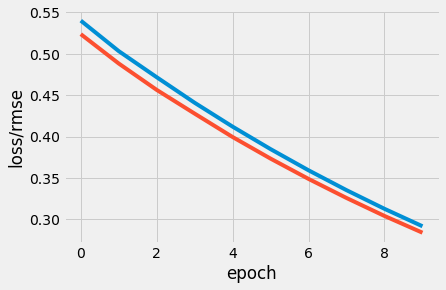

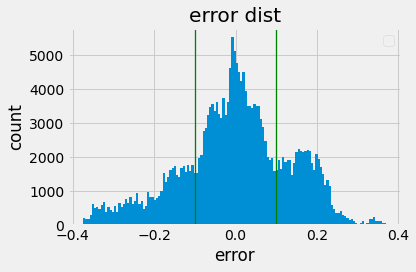

In [91]:
eval_and_output(model, history.history)

plt.legend()
plt.show()

In [75]:
#setup RL with a max of 10 states and defines score by increasing value of money+stockval
